In [2]:
# notebooks/3_activation_importance.ipynb

import torch
import random
import numpy as np
import os
import sys
from tqdm import tqdm

# Add the project root directory to sys.path for importing project modules
project_root = os.path.abspath("..")
sys.path.append(project_root)

# Import utility functions from the project
from src.data_utils import load_datasets, build_few_shot_prompts
from src.model_utils import load_model_and_tokenizer
from src.activations import (
    ActivationHookManager, 
    save_activations, 
    load_activations, 
    aggregate_task_activations, 
    plot_selected_neurons_activations,
    load_weight_l2_info
)


In [3]:
# Hyperparameters and Paths
MODEL_NAME = "Llama-2-7b-hf"  # Model name to be used
MODELS_ROOT_PATH = "../../models"  # Path to store models
ACTIVATIONS_ROOT_PATH = '../activations'  # Path to store activation data


In [4]:
# Data processing parameters
SAMPLE_SIZE = 100  # Number of samples to extract from the training dataset


In [5]:
# Set random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [6]:
# Few-shot training hyperparameters
MIN_SHOT = 1  # Minimum number of examples for few-shot learning
MAX_SHOT = 3  # Maximum number of examples for few-shot learning


In [7]:
# Paths to save activations and weight L2 information
activations_path = os.path.join(ACTIVATIONS_ROOT_PATH, MODEL_NAME)
weight_l2_path = os.path.join(activations_path, 'weight_l2_info.pt')


In [ ]:
# Load datasets
data_dir = '../data/processed'
datasets = load_datasets(data_dir, split='train')

Loaded wikitext2 dataset from train split, shape: (36718, 6)
Loaded hellaswag dataset from train split, shape: (39905, 6)
Loaded gsm8k dataset from train split, shape: (7473, 6)
Loaded winogrande dataset from train split, shape: (2558, 6)
Loaded boolq dataset from train split, shape: (9427, 6)
Loaded obqa dataset from train split, shape: (4957, 6)
Loaded piqa dataset from train split, shape: (16113, 6)
Loaded mmlu dataset from train split, shape: (99842, 6)
Loaded ai2_arc dataset from train split, shape: (1119, 6)


In [ ]:
# Build Few-shot Prompts
shot_inputs, task_types = build_few_shot_prompts(
    datasets,
    min_shot=MIN_SHOT,  # Minimum number of examples for few-shot prompts
    max_shot=MAX_SHOT,  # Maximum number of examples for few-shot prompts
    seed=SEED,  # Set the seed for reproducibility
    sample_size=200,  # Sample size for the prompts
    use_corpus=True  # Use corpus directly instead of few-shot examples
)


In [ ]:
# Load Model and Tokenizer
model_path = os.path.join(MODELS_ROOT_PATH, MODEL_NAME)  # Path to the model
model, tokenizer = load_model_and_tokenizer(model_path)  # Load the model and tokenizer


In [ ]:
# Register Activation Hooks
hook_manager = ActivationHookManager()  # Initialize the activation hook manager
hook_manager.register_activation_hooks(model)  # Register hooks to capture activations


In [ ]:
# Save Activations
with torch.no_grad():  # Disable gradient tracking
    save_activations(
        model=model,
        tokenizer=tokenizer,
        hook_manager=hook_manager,
        shot_inputs=shot_inputs,
        task_types=task_types,
        output_root=activations_path  # Path to save the activations
    )

In [8]:
# Load Activations
task_activations = load_activations(root_path=activations_path)  # Load activations from disk


Loading: obqa


/mnt/data131/hanyu/SEAD/src/activations.py:241: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_acts = torch.load(activations_file)


Loading: gsm8k
Loading: ai2_arc
Loading: boolq
Loading: wikitext2
Loading: hellaswag
Loading: winogrande
Loading: piqa


In [9]:
# Aggregate Task Activations
aggregated_data = aggregate_task_activations(task_activations)  # Aggregate activations by task


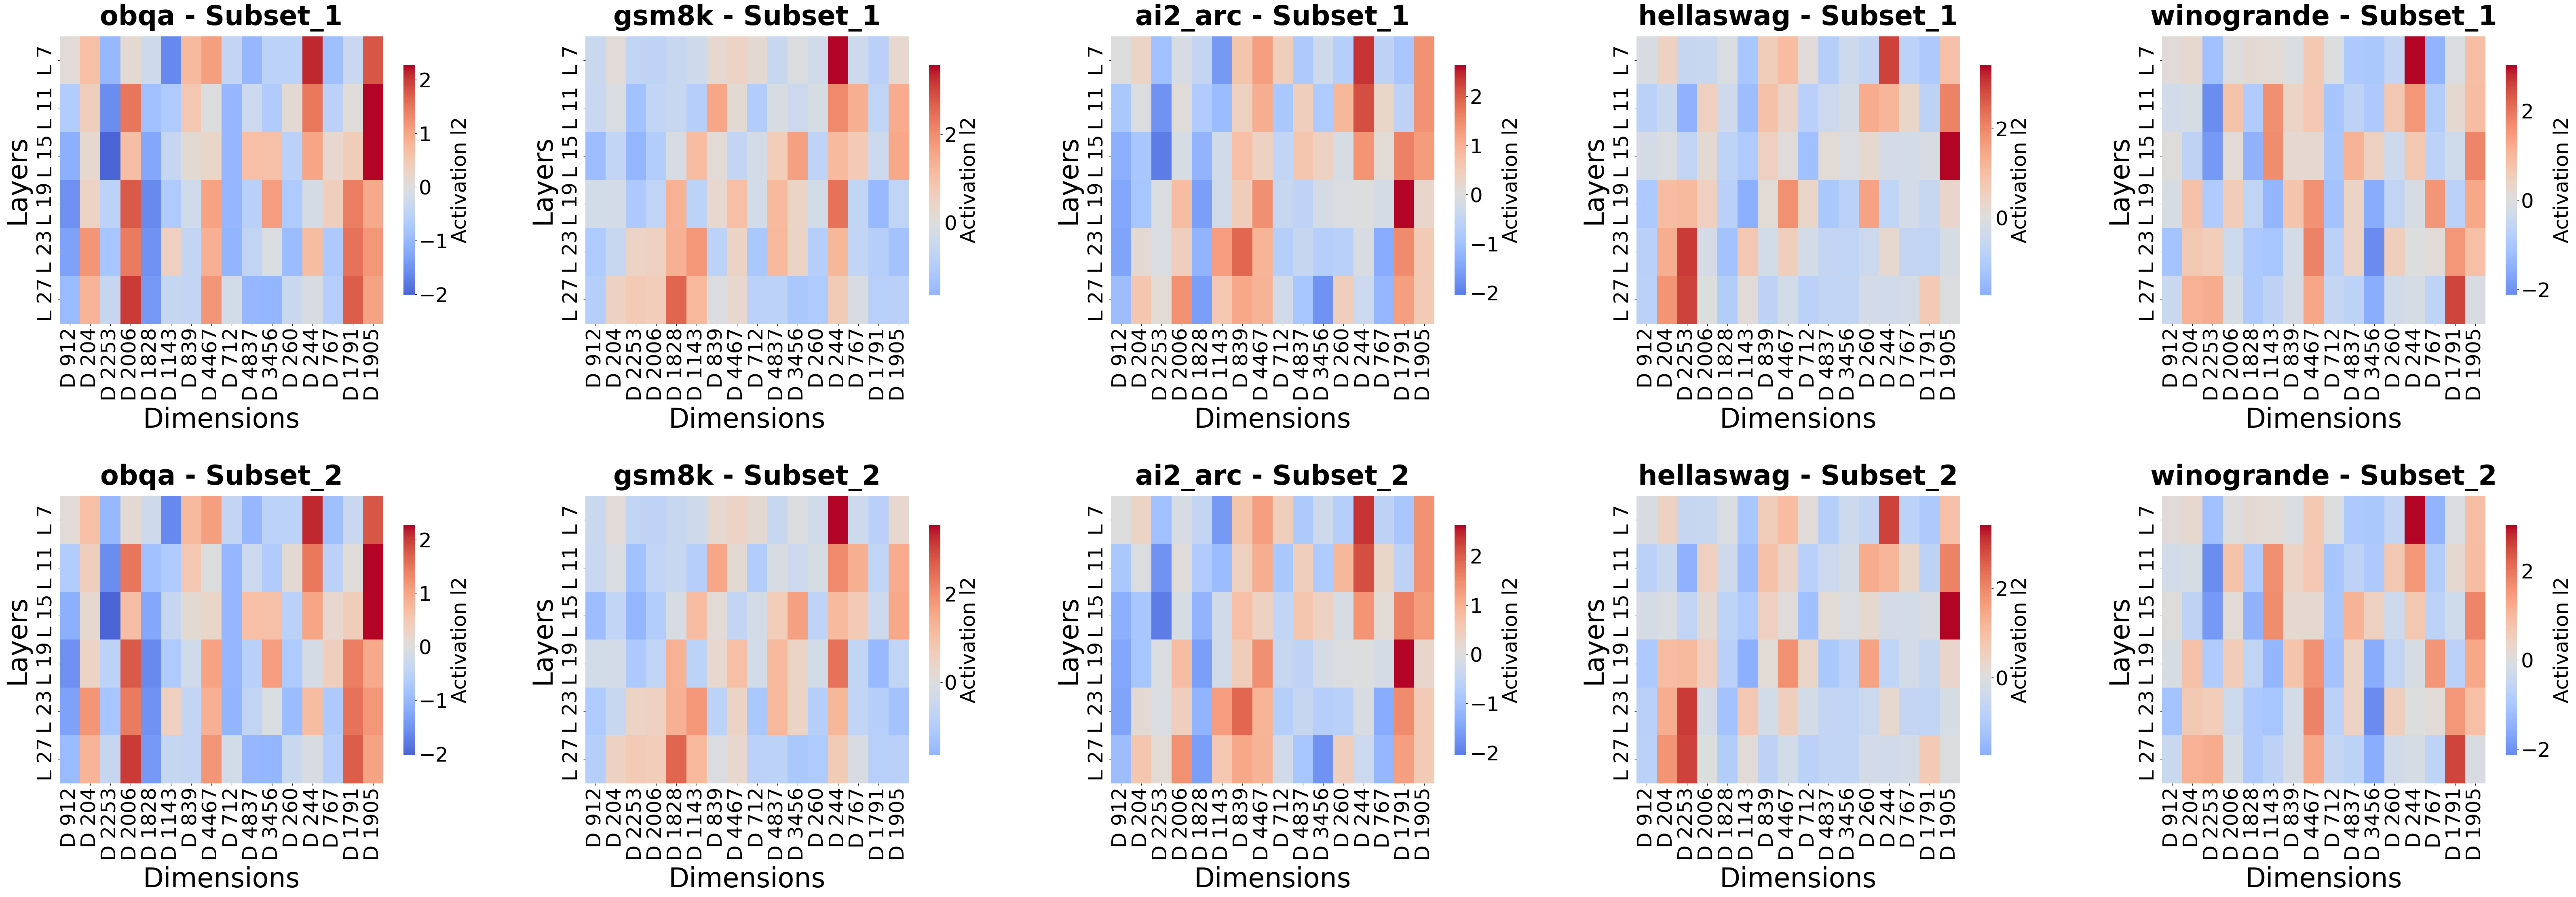

In [17]:
# Visualize Selected Neurons Activations
plot_selected_neurons_activations(
    aggregated_data,
    layers_to_plot=[7, 11, 15, 19, 23, 27],  # Layers to plot (can be adjusted as needed)
    neuron_indices=16,  # Number of neurons to visualize
    subsets=['Subset_1', 'Subset_2'],  # Subsets of data to visualize
    module_name='attention_input_states',  # Module name for activation data
    task_indices=[0, 1, 2, 5, 6],  # Task indices to visualize
    plot_field='l2',  # Field to visualize (e.g., L2 norm)
    fontsize=48,  # Font size for titles
    tick_fontsize=36,  # Font size for tick labels
    random_seed=SEED,  # Set the random seed for reproducibility
    normalize=True  # Normalize the data before plotting
)

In [11]:
# Load Weight L2 Information
weight_l2_data = load_weight_l2_info(weight_l2_path)  # Load L2 norm information of the model's weights

Loaded weight L2 info from ../activations/Llama-2-13b-hf/weight_l2_info.pt


/mnt/data131/hanyu/SEAD/src/activations.py:279: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_l2_data = torch.load(weight_l2_file)
